<a href="https://colab.research.google.com/github/longjuice234/dsl-2025/blob/main/DSL_Stopwatch_(Group_5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/pe8sutd/eda4u &> /dev/null
!git clone https://github.com/pe8sutd/eda4u &> /dev/null
%load_ext plugin

---
# Design steps:
1. Create a new Vivado Project
— Use Basys3 Board
2. Create Constraint file
— Select Switches, Buttons, Segments, etc to be used
3. Create Design Source
— Input Verilog code
4. Create Simulation file
— Input Testbench Code, set simulation file as top
5. Run Simulation
6. Program device

---
#Code Breakdown
The verilog program is divided into 3 main modules: the clocks, the 7-segment display, and the debouncer

##The Clocks

There are 2 subsections of code that make up the internal clock of the program

###1Hz Clock
This module allows the program to count the passage of time in seconds. The clock of the FPGA board is set to 100MHz, which is brought down to 1Hz, and the seconds counter is updated every 1Hz.

```
// 1Hz clock
module clk_1hz(output reg clk_out, input clk_in, input rst);
    reg [25:0] count;
    always @(posedge clk_in) begin
        if (rst)
            count <= 0;
        else if (count == 49999999) begin   // 100MHz to 1Hz
            clk_out <= ~clk_out;
            count <= 0;
        end else begin
            count <= count + 1;
        end
    end
endmodule
```
###500Hz Clock
This module is used to refresh the display. The display only shows one number at a time, so this module refreshes the value every 500Hz to update each 7-segment display to show the numbers.
```
// 500Hz clock
module clk_500hz(output reg clk_out, input clk_in, input rst);
    reg [23:0] count;
    always @(posedge clk_in) begin
        if (count == 99999) begin       // 100MHz to 500Hz
            clk_out <= ~clk_out;
            count <= 0;
        end
        else begin
            count <= count + 1;
        end
    end
endmodule
```

##The 7-segment display
This module determines which bits in the 7-segment display need to be turned on to show specific numbers. The logic for this module was determined by simplifying the required process and updating it bit by bit.


1. Create a Verilog module to display number '1' on the L1 only, while the rest of L3, L2, L0 are off, by setting an[3:0] (an[3], an[2], an[1], an[0]) at a proper logic (0, or 1). Please verify if an must HIGH or LOW to turn on a SSD.

```
%%verilog

module ssd(output[6:0]seg,output[3:0]an,input[3:0]sw);

assign seg=7'b1111001; //LEDs in SSD
assign an=4'b1101; //an, LOW to on L1

endmodule
```

2. In the above exercise, turn ON or OFF a SSD is preset. How to select with SSD to turn ON manually? Creat a Verilog module to display number '1' on the L3, L2, L1, or L0, by selecting inputs sw[3:0] (sw[3], sw[2], sw[1], sw[0]).

```
%%verilog

module ssd(output[6:0]seg,output[3:0]an,input[3:0]sw);

assign seg=7'b1111001; //LEDs in SSD, new orientation
assign an=sw; //sw to control an, LOW to on

endmodule
```

3. In the above exercise, number to be display is preset. How to select the display number manually? Creat a Verilog module to display numbers (0 to 9, by setting sw[7:4]) on the L3, L2, L1, or L0 （selecting inputs sw[3:0]).

```
%%verilog

module ssd(output reg[6:0]seg,output[3:0]an,input[7:0]sw);

always@(sw[7:4]) begin case(sw[7:4])
4'b0000:seg <= 7'b1000000;
4'b0001:seg <= 7'b1111001;
4'b0010:seg <= 7'b0100100;
4'b0011:seg <= 7'b0110000;
4'b0100:seg <= 7'b0011001;
4'b0101:seg <= 7'b0010010;
4'b0110:seg <= 7'b0000010;
4'b0111:seg <= 7'b1111000;
4'b1000:seg <= 7'b0000000;
4'b1001:seg <= 7'b0010000;
default:seg <= 7'b0000110;
endcase end

assign an=sw[3:0]; //sw to control an, LOW to on

endmodule
```

4. Repeat Q2, but using only sw[1:0] to select L0 to L3 to display number '1'.

```
%%verilog

module ssd(output[6:0]seg,output reg[3:0]an,input[1:0]sw);
  assign seg=7'b1111001;
  always@(sw[1:0])
  begin case(sw[1:0])
    2'b00:an<=4'b1110;
    2'b01:an<=4'b1101;
    2'b10:an<=4'b1011;
    2'b11:an<=4'b0111;
    endcase
  end
endmodule
```

5. In Figure: Basys-3 board features, it shows 5 pushbuttons (Callout-7). By using btnC, to display number '1' on L0, when press btnC. No number will be displayed when btnC is released.

```
%%verilog

module ssd(output[6:0]seg,output[3:0]an,input btnC);
  assign seg=7'b1111001;
  assign an=(btnC) ? 4'b1110 : 4'b1111;
endmodule
```

6. Using btnC to display the number '1' on L0, L1, L2, L3 in sequence. You need to use debounded_btnC as the following debounce module. The FPGA Basys 3 requires debounce module to handle the pushbuttons.

```
%%verilog

module ssd(output[6:0]seg,output reg[3:0]an,input btnC,btnR,clk);
  reg[1:0]count;
  assign seg=7'b1111001;

  //btnR as reset?
  debounce d0 (.clk(clk),.reset(btnR),.button_in(btnC),.button_out(debounced_btnC));

  always@(posedge debounced_btnC)
    if (count != 2'b11) count <= count+1'b1;
    else count <= 2'b00;

  always@(count) begin case(count)
    2'b00: an<=4'b1110;
    2'b01: an<=4'b1101;
    2'b10: an<=4'b1011;
    2'b11: an<=4'b0111;
  endcase end

endmodule

//////////////////////////////////////////////////////////////////
module debounce (
    input wire clk,        // System clock (e.g., 100 MHz on Basys 3)
    input wire reset,      // Reset signal
    input wire button_in,  // Raw button input
    output reg button_out  // Debounced button output
);

    reg [19:0] count;      // 20-bit counter for debouncing
    reg button_prev;        // Previous state of the button

    always @(posedge clk or posedge reset) begin
        if (reset) begin
            count <= 20'b0;
            button_prev <= 1'b0;
            button_out <= 1'b0;
        end else begin
            button_prev <= button_in;
            if (button_prev != button_in) begin
                count <= 20'b0;
            end else if (count == 20'hFFFFF) begin
                button_out <= button_prev;
            end else begin
                count <= count + 1;
            end
        end
    end

endmodule
//////////////////////////////////////////////////////////////////
```

7. Pressing the pushbuttons to display the number in sequence require manual work, which may not available most of the time. Then how? In Q6, clk (100 MHz in Basys-3) is used for the debounce module. The input to the debounce module is btnC (pressing by you!), and the output is debounce_btnC to trigger the 2-bit counter, which provide the state for the case statement controlling the SSD (L0 to L3) automatically. Similarily:

    - Using clk (100 MHz in Basys-3 board) as an input to a first counter that gives approximately 10 Hz clock, clk_10hz, which replace the debounce module.

    - Using clk_10hz as an input to the 2-bit counter in Q6.

```
%%verilog

module ssd(output[6:0]seg,output reg[3:0]an,input btnR,input clk);
  reg[1:0]count; wire clk_500hz;
  assign seg=7'b1111001;

  clk_500hz c0 (.clk_out(clk_500hz),.clk_in(clk),.reset(btnR));

  always@(posedge clk_500hz)
    if (count != 2'b11) count <= count+1'b1;
    else count <= 2'b00;

  always@(count) begin case(count)
    2'b00: an<=4'b1110;
    2'b01: an<=4'b1101;
    2'b10: an<=4'b1011;
    2'b11: an<=4'b0111;
  endcase end

endmodule

module clk_500hz(output reg clk_out,input clk_in,rst); reg[23:0]count;
  always@(posedge clk_in) begin
    if(rst)
      count <= 24'h000000;
    else if (count == 19999)begin
      clk_out <= 1'b1; count <= 24'h000000;
      end

    else begin
      count <= count + 1'b1;
      clk_out <=1'b0;
      end
    end

endmodule
```
The debounce module will be explained in the next section.


--

**Final 7-segment display code**
```
// 7-segment decoder logic
always @(*) begin
    case (cur_num_r)
        4'h0: seg = 7'b1000000; // 0
        4'h1: seg = 7'b1111001; // 1
        4'h2: seg = 7'b0100100; // 2
        4'h3: seg = 7'b0110000; // 3
        4'h4: seg = 7'b0011001; // 4
        4'h5: seg = 7'b0010010; // 5
        4'h6: seg = 7'b0000010; // 6
        4'h7: seg = 7'b1111000; // 7
        4'h8: seg = 7'b0000000; // 8
        4'h9: seg = 7'b0010000; // 9
        default: seg = 7'b1111111; // All segments off
    endcase
end
```

##The Debouncer
This module ensures that when a button is pressed once, it only triggers one signal, and removes additional signals.

```
// Debounce Module
module debounce (
    output reg button_out,
    input wire clk,
    input wire reset,
    input wire button_in
);
    reg [21:0] count;
    reg button_prev;

    always @(posedge clk or posedge reset) begin
        if (reset) begin
            count <= 0;
            button_prev <= 0;
            button_out <= 0;
        end else begin
            button_prev <= button_in;
            if (button_prev != button_in) begin
                count <= 0;
            end else if (count == 22'hFFFFF) begin // debounce time
                button_out <= button_prev;
            end else begin
                count <= count + 1;
            end
        end
    end
endmodule
```

##Constraint File
```
## Clock signal
set_property -dict { PACKAGE_PIN W5   IOSTANDARD LVCMOS33 } [get_ports clk]
create_clock -add -name sys_clk_pin -period 10.00 -waveform {0 5} [get_ports clk]

##7 Segment Display
set_property -dict { PACKAGE_PIN W7   IOSTANDARD LVCMOS33 } [get_ports {seg[0]}]
set_property -dict { PACKAGE_PIN W6   IOSTANDARD LVCMOS33 } [get_ports {seg[1]}]
set_property -dict { PACKAGE_PIN U8   IOSTANDARD LVCMOS33 } [get_ports {seg[2]}]
set_property -dict { PACKAGE_PIN V8   IOSTANDARD LVCMOS33 } [get_ports {seg[3]}]
set_property -dict { PACKAGE_PIN U5   IOSTANDARD LVCMOS33 } [get_ports {seg[4]}]
set_property -dict { PACKAGE_PIN V5   IOSTANDARD LVCMOS33 } [get_ports {seg[5]}]
set_property -dict { PACKAGE_PIN U7   IOSTANDARD LVCMOS33 } [get_ports {seg[6]}]

set_property -dict { PACKAGE_PIN U2   IOSTANDARD LVCMOS33 } [get_ports {an[0]}]
set_property -dict { PACKAGE_PIN U4   IOSTANDARD LVCMOS33 } [get_ports {an[1]}]
set_property -dict { PACKAGE_PIN V4   IOSTANDARD LVCMOS33 } [get_ports {an[2]}]
set_property -dict { PACKAGE_PIN W4   IOSTANDARD LVCMOS33 } [get_ports {an[3]}]


##Buttons
set_property -dict { PACKAGE_PIN U18   IOSTANDARD LVCMOS33 } [get_ports btnC]
set_property -dict { PACKAGE_PIN W19   IOSTANDARD LVCMOS33 } [get_ports btnL]
set_property -dict { PACKAGE_PIN T17   IOSTANDARD LVCMOS33 } [get_ports btnR]


## Configuration options, can be used for all designs
set_property CONFIG_VOLTAGE 3.3 [current_design]
set_property CFGBVS VCCO [current_design]

## SPI configuration mode options for QSPI boot, can be used for all designs
set_property BITSTREAM.GENERAL.COMPRESS TRUE [current_design]
set_property BITSTREAM.CONFIG.CONFIGRATE 33 [current_design]
set_property CONFIG_MODE SPIx4 [current_design]
```

---
#Verilog Code:

In [ ]:
%%verilog

//`timescale 1ns / 1ps       UNCOMMENT THS LINE FOR VIVADO AND DELETE THE PREVIOUS
//////////////////////////////////////////////////////////////////////////////////
// Company:
// Engineer:
//
// Create Date: 08.03.2025 11:59:01
// Design Name:
// Module Name: stopwatch
// Project Name:
// Target Devices:
// Tool Versions:
// Description:
//
// Dependencies:
//
// Revision:
// Revision 0.01 - File Created
// Additional Comments:
//
//////////////////////////////////////////////////////////////////////////////////


module stopwatch(
    output reg [3:0] an,   // Anode control for 7-segment display
    output reg [6:0] seg,  // Segment control
    input btnR,            // Reset button
    input btnC,            // Start/Stop button
    input clk              // 100MHz
);

reg [3:0] min_tens = 0;
reg [3:0] min_ones = 0;
reg [3:0] sec_tens = 0;
reg [3:0] sec_ones = 0;
reg running = 1'b1;     // Stopwatch running state
reg [1:0] an_r = 0;     // Anode rotation bit
reg [3:0] cur_num_r;    //get 1 digit number for 7-segment display

// Debounced button instantiation
wire debounced_btnC;
debounce d0 (.button_out(debounced_btnC), .clk(clk), .reset(btnR), .button_in(btnC));

// Clock instantiation
wire clk_500hz;
clk_500hz c0(.clk_out(clk_500hz), .clk_in(clk), .rst(btnR));

wire clk_1hz;
clk_1hz c1(.clk_out(clk_1hz), .clk_in(clk), .rst(btnR));

// anode rotation logic
always @(posedge clk_500hz) begin
    an_r <= an_r + 1;
    case(an_r)
        2'b00: an <= 4'b1110;
        2'b01: an <= 4'b1101;
        2'b10: an <= 4'b1011;
        2'b11: an <= 4'b0111;
    endcase
end

// Digit selection
always @(*) begin
    case (an)
        4'b1110: cur_num_r = sec_ones; // LSB
        4'b1101: cur_num_r = sec_tens;
        4'b1011: cur_num_r = min_ones;
        4'b0111: cur_num_r = min_tens; // MSB
        default: cur_num_r = 4'b1111;
    endcase
end

// 7-segment decoder logic
always @(*) begin
    case (cur_num_r)
        4'h0: seg = 7'b1000000; // 0
        4'h1: seg = 7'b1111001; // 1
        4'h2: seg = 7'b0100100; // 2
        4'h3: seg = 7'b0110000; // 3
        4'h4: seg = 7'b0011001; // 4
        4'h5: seg = 7'b0010010; // 5
        4'h6: seg = 7'b0000010; // 6
        4'h7: seg = 7'b1111000; // 7
        4'h8: seg = 7'b0000000; // 8
        4'h9: seg = 7'b0010000; // 9
        default: seg = 7'b1111111; // All segments off
    endcase
end

// start,stop and reset
always @(btnR or debounced_btnC) begin
    if (btnR)
        running <= 0;           // Stop when reset
    else if (debounced_btnC)
        running <= ~running;    // Toggle running state
end


// stopwatch logic
always @(posedge clk_1hz or posedge btnR) begin
    if (btnR) begin     // reset when btnR pressed
        min_tens <= 0;
        min_ones <= 0;
        sec_tens <= 0;
        sec_ones <= 0;
     end
     else if (running) begin // 1 sec
        sec_ones <= sec_ones + 1;

            if (sec_ones == 9) begin // 10 sec
                sec_ones <= 0;
                sec_tens <= sec_tens + 1;
            end

            if (sec_tens == 5 && sec_ones == 9) begin // 1 min
                sec_tens <= 0;
                min_ones <= min_ones + 1;
            end

            if (min_ones == 9 && sec_tens == 5 && sec_ones == 9) begin // 10 min
                min_ones <= 0;
                min_tens <= min_tens + 1;
            end

            if (min_tens == 9 && min_ones == 9 && sec_tens == 5 && sec_ones == 9) begin // overflow 100 min
                min_tens <= 0;
                min_ones <= 0;
                sec_tens <= 0;
                sec_ones <= 0;
            end
        end
    end

endmodule

// 500Hz clock
module clk_500hz(output reg clk_out, input clk_in, input rst);
    reg [23:0] count;
    always @(posedge clk_in) begin
        if (count == 99999) begin       // 100MHz to 500Hz
            clk_out <= ~clk_out;
            count <= 0;
        end
        else begin
            count <= count + 1;
        end
    end
endmodule

// 1Hz clock
module clk_1hz(output reg clk_out, input clk_in, input rst);
    reg [25:0] count;
    always @(posedge clk_in) begin
        if (rst)
            count <= 0;
        else if (count == 49999999) begin   // 100MHz to 1Hz
            clk_out <= ~clk_out;
            count <= 0;
        end else begin
            count <= count + 1;
        end
    end
endmodule

// Debounce Module
module debounce (
    output reg button_out,
    input wire clk,
    input wire reset,
    input wire button_in
);
    reg [21:0] count;
    reg button_prev;

    always @(posedge clk or posedge reset) begin
        if (reset) begin
            count <= 0;
            button_prev <= 0;
            button_out <= 0;
        end else begin
            button_prev <= button_in;
            if (button_prev != button_in) begin
                count <= 0;
            end else if (count == 22'hFFFFF) begin // debounce time
                button_out <= button_prev;
            end else begin
                count <= count + 1;
            end
        end
    end
endmodule

Installing. Please wait... done!



###Stopwatch Testbench

In [ ]:
%%verilog
module stopwatch(
    input btnR,
    input btnC,
    input clk,
    output [3:0] min_tens,
    output [3:0] min_ones,
    output [3:0] sec_tens,
    output [3:0] sec_ones
);

reg [3:0] min_tens = 0;
reg [3:0] min_ones = 0;
reg [3:0] sec_tens = 0;
reg [3:0] sec_ones = 0;
reg running = 1'b1;
always @(posedge btnR or posedge btnC) begin
    if (btnR)
        running <= 0;           // Stop when reset
    else if (btnC)
        running <= ~running;    // Toggle running state
end


always @(posedge clk or posedge btnR) begin
    if (btnR) begin
        min_tens <= 0;
        min_ones <= 0;
        sec_tens <= 0;
        sec_ones <= 0;
     end
     else if (running) begin
        sec_ones <= sec_ones + 1;

            if (sec_ones == 9) begin
                sec_ones <= 0;
                sec_tens <= sec_tens + 1;
            end

            if (sec_tens == 5 && sec_ones == 9) begin
                sec_tens <= 0;
                min_ones <= min_ones + 1;
            end

            if (min_ones == 9 && sec_tens == 5 && sec_ones == 9) begin
                min_ones <= 0;
                min_tens <= min_tens + 1;
            end

            if (min_tens == 9 && min_ones == 9 && sec_tens == 5 && sec_ones == 9) begin
                min_tens <= 0;
                min_ones <= 0;
                sec_tens <= 0;
                sec_ones <= 0;
            end
        end
    end

endmodule

// 1Hz clock
module tb;
    reg btnR;
    reg btnC;
    reg clk;
    wire [3:0] min_tens;
    wire [3:0] min_ones;
    wire [3:0] sec_tens;
    wire [3:0] sec_ones;

stopwatch uut(btnR, btnC, clk, min_tens, min_ones, sec_tens, sec_ones);

initial begin
clk = 0;
forever #1 clk = ~clk;
end

initial begin
    $dumpfile("tb.vcd");
    $dumpvars(0, tb);
end

initial begin
btnR = 1'b0;
btnC = 1'b0;
#5 btnC = 1'b1;
#5 btnC = 1'b0;
#5 btnC = 1'b1;
#5 btnC = 1'b0;
#5 btnR = 1'b1;
#5 btnR = 1'b0;
#5 btnC = 1'b1;
#5 btnC = 1'b0;
#10000 $finish;
$dumpoff;
end

endmodule

VCD info: dumpfile tb.vcd opened for output.



---

#Simulation

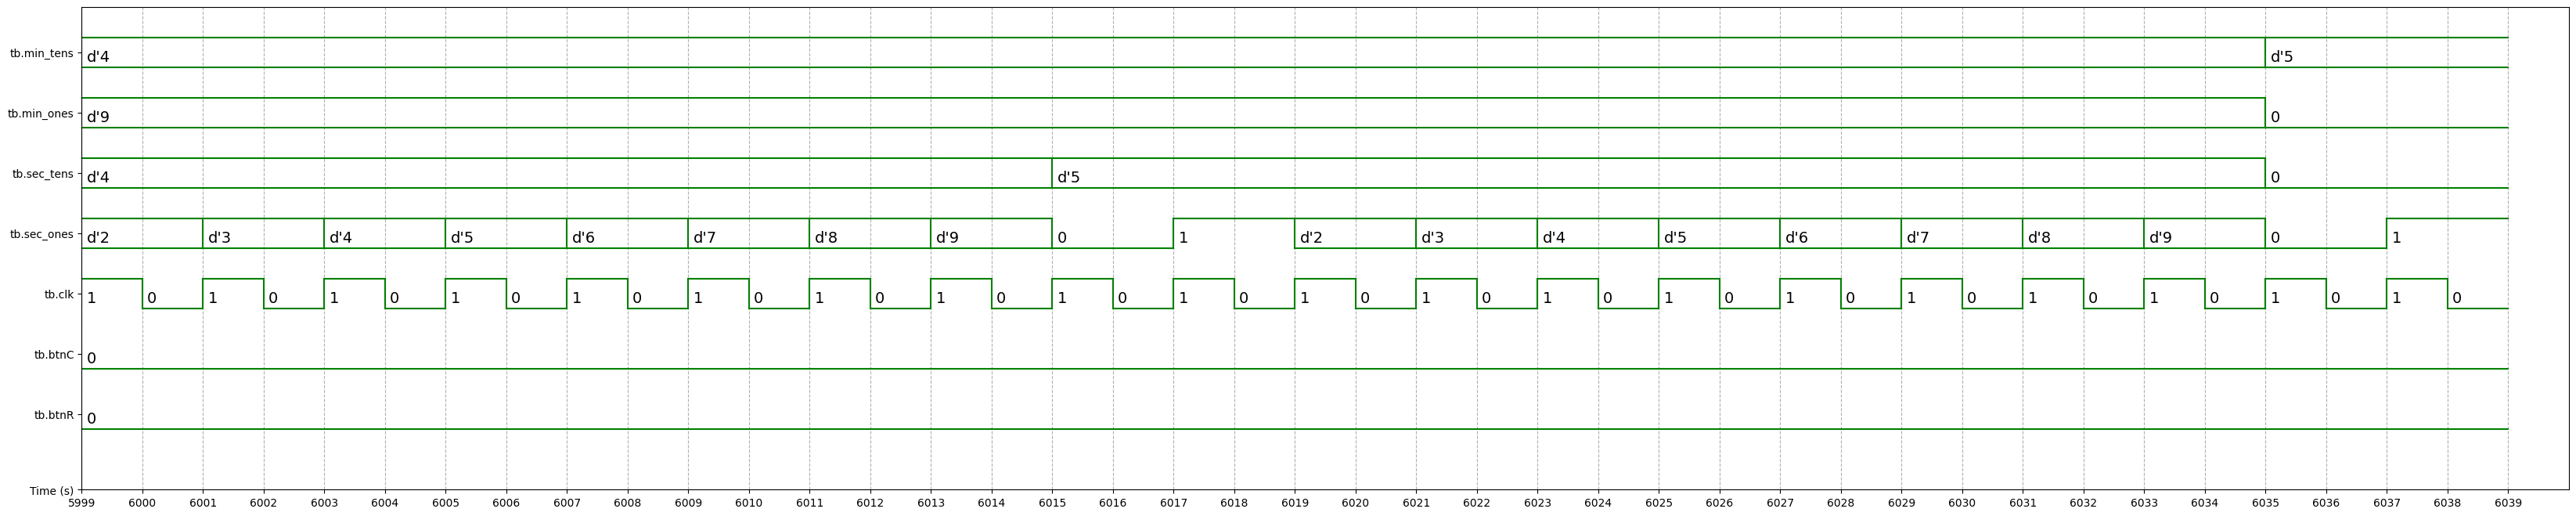

In [ ]:
%%waveform tb.vcd
sign_list = ["tb.min_tens","tb.min_ones", "tb.sec_tens","tb.sec_ones", "tb.clk", "tb.btnC","tb.btnR"]
time_begin = 5999
time_end = 6039
base = 'dec'

---
#Video
[DSL Stopwatch project (Group 5)](https://github.com/longjuice234/dsl-2025/blob/main/DSL%20Stopwatch%20Video%20(Group%205).mp4)



---
#Challenges
- Had to decouple the 500Hz clock for the stopwatch logic as it causes display issues when resetting. The display stopped at one 7-segment display when reset. Ended up using two separate clocks; one for display, and the other for counting.
- Tried a few different types of stopwatch logic as there was a mistake in the if-else statement.
- Did not properly understand how the clock worked and resulted in timing taking twice as long (for the 500Hz clock).
- Debounce module could not work as delay was too short.
- Gemini code did not work because it assumed that each 7-segment is writable to.
- ChatGPT code had the same issues as Gemini as it assumed that each 7-segment is writable to.


---
#AI Usage

AI was primarily used to help write code, but due to both LLMs assuming that each 7-segment could be written to, the code kept failing. In addition, the code generated would count incorrectly. Sensibly, we stopped using Gemini and ChatGPT early on in the project.